# 1. MNIST

In [2]:
# Python 3.5 이상 필요
import sys
assert sys.version_info >= (3, 5)

# Colab 또는 Kaggle 실행 여부 확인
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn 0.20 이상 필요
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 랜덤 시드 고정
np.random.seed(42)

# 그래프 설정
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)   # 축 라벨 크기
mpl.rc('xtick', labelsize=12)  # x축 눈금 크기
mpl.rc('ytick', labelsize=12)  # y축 눈금 크기

# 이미지 저장 경로 설정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 이미지 저장 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()  # 여백 정리
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
# data: 각 행이 하나의 샘플(이미지), 각 열이 하나의 특성(피처)인 배열
# target: 레이블(정답)을 담고 있는 배열
# DESCR: 데이터셋에 대한 설명

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [14]:
X, y = mnist["data"], mnist["target"]    # 입력 데이터와 레이블 분리
X.shape    # 총 70,000개의 이미지가 있으며, 각 이미지는 784개의 특성(feature) 가짐!

(70000, 784)

In [4]:
y.shape

(70000,)

In [13]:
28 * 28    # 28 × 28 = 784개의 픽셀
           # 각 특성 = 픽셀 하나의 밝기 값(0 ~ 255)

784

Saving figure some_digit_plot


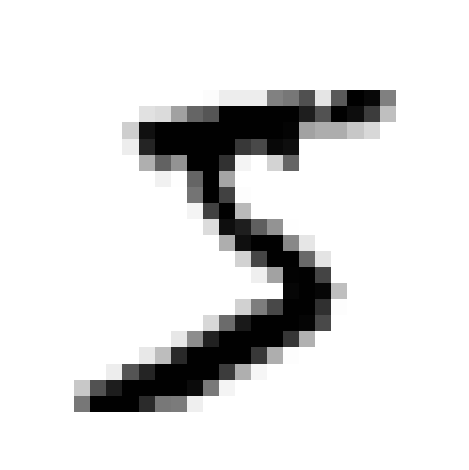

In [24]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt   # 노트북에 그래프 출력

some_digit = X[0]  # 첫 번째 샘플
some_digit_image = some_digit.reshape(28, 28)  # 28×28 이미지로 변환

plt.imshow(some_digit_image, cmap=mpl.cm.binary)  # 흑백 이미지 출력
                                                  # binary	밝은 배경에 어두운 전경
                                                  # gray / Greys	어두운 배경에 밝은 전경
                                                  # viridis	기본 컬러맵 (녹색-보라 등)
                                                  # hot	빨강-노랑 계열의 열 이미지
plt.axis("off")  # 축 제거

save_fig("some_digit_plot")  # 이미지 저장
plt.show()  # 화면에 출력


In [32]:
y[0]  # 실제 레이블 확인

np.uint8(5)

In [28]:
y = y.astype(np.uint8) # 현재 레이블은 string이고, 대부분의 머신러닝 알고리즘은 숫자 형식의 레이블을 기대함
                       # y를 정수형으로 변환

In [151]:
def plot_digit(data):
    image = data.reshape(28, 28)                         # 1차원 벡터를 28x28 이미지로 변환
    plt.imshow(image, cmap=mpl.cm.binary,               # 흑백 이미지로 표시
               interpolation="nearest")                 # 보간 없이 픽셀 그대로 표시
    plt.axis("off")                                     # 축 숨기기


In [34]:
# 여러 숫자 이미지 한꺼번에 출력
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)  # 행당 최대 이미지 수
    n_rows = (len(instances) - 1) // images_per_row + 1  # 전체 행 수 계산

    # 빈 이미지 추가 (모양 맞추기)
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # (행, 열, 28, 28) 형태로 변환
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 2D 큰 이미지로 결합
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 출력
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")


Saving figure more_digits_plot


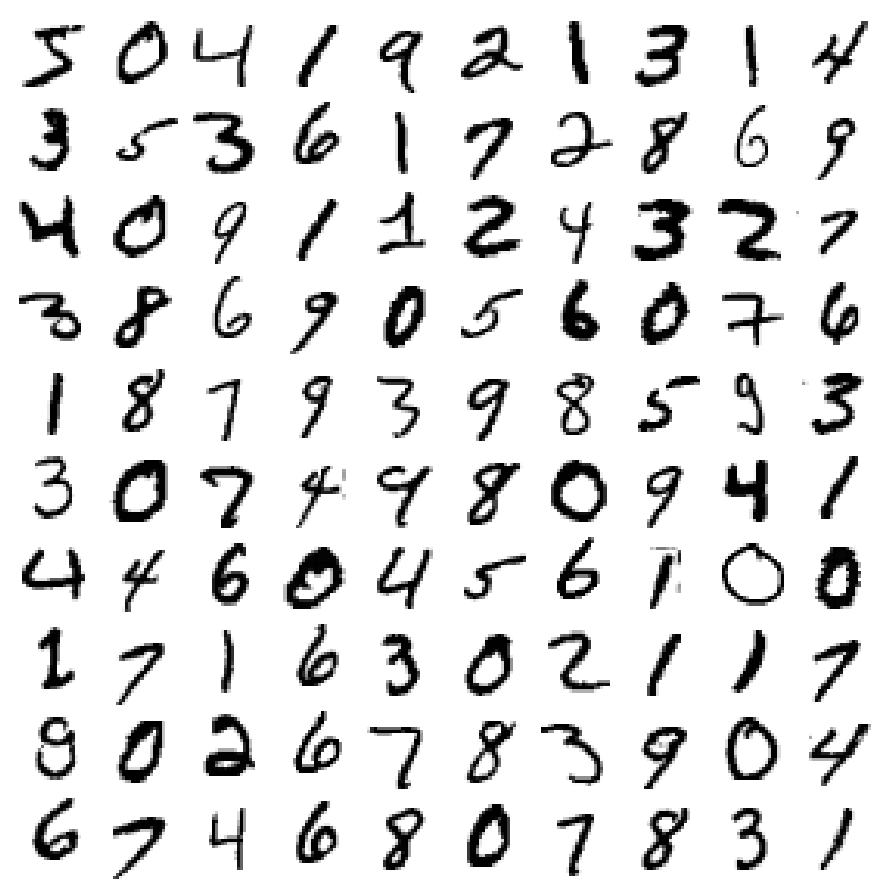

In [35]:
plt.figure(figsize=(9, 9))  # 그림 크기 설정 (9x9인치)
example_images = X[:100]  # 앞에서 100개 이미지 선택
plot_digits(example_images, images_per_row=10)  # 10개씩 가로로 출력
save_fig("more_digits_plot")  # 이미지 저장
plt.show()  # 화면에 출력


In [37]:
X_train, X_test = X[:60000], X[60000:]  # 입력 데이터 분할 (훈련/테스트)
y_train, y_test = y[:60000], y[60000:]  # 레이블 분할 (훈련/테스트)
# 데이터는 이미 섞여 있음 -> 교차 검증 공정성 확보, 순서 민감도 완화

# 2. Training a Binary Classifier

특정 숫자 하나만 식별하기(숫자 5)  
-> 이진 분류기(binary classifier)의 예

In [41]:
# 분류 작업을 위한 타깃 벡터 생성
y_train_5 = (y_train == 5)  # 5이면 True, 아니면 False
y_test_5 = (y_test == 5)

In [42]:
# SGDClassifier: 큰 데이터셋도 효율적으로 처리할 수 있음
# -> SGD(확률적 경사 하강법)가 한 번에 하나의 훈련 샘플만 처리하기 때문!(온라인 학습에 적합)

# SGDClassifier 생성, 전체 훈련 데이터에 대해 학습
from sklearn.linear_model import SGDClassifier  # SGD 분류기 불러오기
sgd_clf = SGDClassifier(random_state=42)       # 모델 생성 (랜덤 고정: SGDClassifier는 학습 과정에서 무작위성 사용, 재현 가능하도록 매개변수 설정)
sgd_clf.fit(X_train, y_train_5)                # 훈련 (5 vs not 5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [43]:
sgd_clf.predict([some_digit])  # 숫자 5인지 예측 (True: 5, False: 다른 숫자)


array([ True])

In [44]:
# SGD 분류기(sgd_clf)의 정확도 평가
# 3-폴드 교차 검증(cross-validation) -> 5 vs 나머지에 대한 정확도(accuracy) 계산
from sklearn.model_selection import cross_val_score  # 교차 검증 함수 불러오기
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")  # 정확도 기준 3폴드 교차 검증

array([0.95035, 0.96035, 0.9604 ])

# 3. Performance Measures

## Measuring Accuracy Using Cross-Validation

In [46]:
# 교차 검증 구현(Implementing Cross-Validation)

# Scikit-Learn에서 기본으로 제공하는 것보다 교차 검증 프로세스를 더 세부적으로 제어하기(교차 검증 직접 구현)
# Scikit-Learn의 cross_val_score() 함수와 거의 동일한 작업을 수행하며, 동일한 결과 출력

from sklearn.model_selection import StratifiedKFold  # 층화 K-폴드 분할
from sklearn.base import clone  # 모델 복제용

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3폴드 교차 검증 설정
# StratifiedKFold 클래스는 층화 샘플링을 수행하여 각 클래스의 대표 비율을 포함하는 폴드 생성

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # 분류기 복제 (초기화 상태로)
    
    # 훈련 폴드와 검증 폴드 분리
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  # 모델 훈련
    y_pred = clone_clf.predict(X_test_fold)      # 예측 수행
    n_correct = sum(y_pred == y_test_fold)       # 맞춘 개수 계산
    print(n_correct / len(y_pred))               # 정확도 출력


0.9669
0.91625
0.96785


In [47]:
from sklearn.base import BaseEstimator

# 항상 "5가 아님"이라고 예측하는 더미 분류기 정의
# 목적: 진짜 모델(SGDClassifier 등)의 성능이 '무식한 분류기'보다 나은지 비교하기 위한 기준선(baseline) 생성
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass  # 학습 과정 없음 (형식상 메서드만 정의)

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # 항상 False 반환 (즉, 절대 5라고 예측하지 않음)


In [51]:
never_5_clf = Never5Classifier()  # 항상 5가 아니라고 예측하는 기준선 모델 생성
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")  # 기준선 모델 정확도 평가 (3폴드 교차 검증)
# -> 정확도 90% 이상: 10%만 숫자 5이기 때문에, 무조건 "5가 아니다"라고 예측하면 약 90%는 맞게 됨
# 정확도(accuracy)는 특히 데이터가 불균형할 때는 더더욱 좋은 분류 성능 지표가 아님

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

분류기의 성능을 평가하는 훨씬 더 나은 방법: 혼동 행렬(confusion matrix) 살펴보기  
"클래스 A의 샘플이 클래스 B로 잘못 분류된 횟수를 세는 것"  
목적: 모델이 어디서 얼마나 자주 틀리는지 구체적으로 파악  

혼동 행렬을 계산하려면, 먼저 모델의 예측 결과가 있어야 그것을 정답 레이블과 비교할 수 있음  
(테스트 세트에 대해 예측할 수도 있지만, 테스트 세트는 프로젝트 마지막 단계, 모델이 완성되었을 때만 사용)

In [55]:
# 대안: cross_val_predict() 사용하기

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# cross_val_predict(): cross_val_score()처럼 K-겹 교차 검증을 수행하지만, 점수 대신 각 샘플의 예측 결과 반환
# clean prediction: 훈련 데이터의 각 샘플마다, 그 샘플을 보지 않고 훈련된 모델이 예측한 결과 반환

In [58]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# [[TN, FP] TN(True Negative):	실제 0이고 예측도 0, FP(False Positive): 실제 0인데 예측은 1
# [FN, TP]] FN(False Negative):	실제 1인데 예측은 0, TP(True Positive):	실제 1이고 예측도 1

array([[53892,   687],
       [ 1891,  3530]])

In [59]:
y_train_perfect_predictions = y_train_5  # 완벽한 예측이라고 가정 (실제값과 동일하게 설정)
confusion_matrix(y_train_5, y_train_perfect_predictions)  # 혼동 행렬 계산 (예측 = 실제일 때)


array([[54579,     0],
       [    0,  5421]])

양성 예측의 정확도를 정밀도(Precision)라고 한다.  

$$
\text{Precision} = \frac{TP}{TP + FP}
$$


정밀도는 일반적으로 재현율(recall)이라는 또 다른 지표와 함께 사용되며,   
민감도(sensitivity) 또는 참 양성률(TPR)이라고도 한다.  
이는 분류기가 올바르게 감지한 양성 인스턴스의 비율이다!

$$
\text{Recall} = \frac{TP}{TP + FN}
$$


![참 부정(왼쪽 상단), 거짓 긍정(오른쪽 상단), 거짓 부정(왼쪽 하단), 참 긍정(오른쪽 하단)](3-2.jpg)


## Precision and Recall

In [66]:
# Scikit-Learn은 정확도와 재현율을 포함하여 분류기 지표를 계산하는 여러 함수를 제공

from sklearn.metrics import precision_score, recall_score  # 정밀도와 재현율 계산 함수 import
precision_score(y_train_5, y_train_pred)    # 정밀도 계산: 예측한 양성 중 실제 양성 비율

0.8370879772350012

In [67]:
cm = confusion_matrix(y_train_5, y_train_pred)  # 혼동 행렬 생성
cm[1, 1] / (cm[0, 1] + cm[1, 1])  # 정밀도 계산: TP / (FP + TP)


np.float64(0.8370879772350012)

In [70]:
recall_score(y_train_5, y_train_pred)  # 재현율 계산: 실제 양성 중에서 맞춘 비율


0.6511713705958311

In [71]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

두 분류기를 간단하게 비교해야 할 때, 정밀도와 재현율을 F1 점수라는 단일 지표로 결합하는 것이 편리  
(F1 점수: 정밀도와 재현율의 조화 평균)  
일반 평균은 모든 값을 동등하게 처리하는 반면, 조화 평균은 낮은 값에 훨씬 더 큰 가중치를 부여  
결과적으로, 분류기는 재현율과 정밀도가 모두 높은 경우에만 높은 F1 점수를 받게 됨

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} 
= 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} 
= \frac{TP}{TP + \frac{FN + FP}{2}}
$$


In [72]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [75]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)   #  F1 점수를 직접 근사

np.float64(0.7325171197343847)

F1 점수는 유사한 정밀도와 재현율을 가진 분류기를 선호하지만, 항상 원하는 것은 X  
어떤 상황에서는 정밀도가 더 중요하고, 다른 상황에서는 재현율이 더 중요  

예를 들어, 어린이에게 안전한 비디오 감지하도록 분류기 훈련 

 - 재현율이 훨씬 높지만 제품에 몇 개의 정말 나쁜 비디오가 표시되는 분류기보다
 - 좋은 비디오를 많이 거부하고(재현율이 낮음) 안전한 비디오만 유지하는(정밀도가 높음) 분류기를 선호할 것
 - (이 경우 분류기의 비디오 선택을 확인하기 위해 인적 파이프라인 추가)

반면, 감시 이미지에서 만취범을 감지하도록 분류기 훈련

 - 분류기의 정밀도가 30%에 불과하더라도 재현율이 99%라면 괜찮음

두 가지 효과를 동시에 얻을 수는 없음  
 -> 정밀도를 높이면 재현율이 떨어지고, 그 반대의 경우도 마찬가지(정밀도/재현율 트레이드오프 Precision/Recall Trade-off)

## Precision/Recall Trade-off

이 정밀도-재현율 간의 균형(trade-off)을 이해하기 위해, SGDClassifier가 어떻게 분류 결정을 내리는지 살펴보기  
이 모델은 각 샘플에 대해 결정 함수(decision function)를 통해 점수를 계산  
이 점수가 기준 임계값(threshold)보다 크면 양성 클래스(positive class)  
그렇지 않으면 음성 클래스(negative class)로 분류  

![정밀도/재현율 균형](3-3.jpg)


임계값이 가운데 화살표(두 개의 5 사이)에 위치해 있다고 가정

 - 이 기준보다 오른쪽에 실제 숫자 5가 4개 있고, 실제 숫자 6이 1개 있음
 - 즉, 이 기준에서는 4개의 TP와 1개의 FP 발생
 - 따라서 이 임계값에서 정밀도는 80%(양성으로 분류된 5개 중 4개가 실제 5)
 - 그러나 실제로는 5가 6개, 이중 4개만 감지 -> 재현율은 67%(6개 중 4개 감지)

임계값을 오른쪽 화살표로 높인다고 가정
 - FN(실제로는 6)이 음성으로 바뀌면서 정밀도는 100%
 - 하지만 그 과정에서 하나의 참 양성이 감지되지 못해 재현율은 50%

반대로 임계값을 낮추면 더 많은 양성을 잡아내 재현율은 높아지지만, 정밀도는 낮아짐  
=> 임계값을 어떻게 조정하느냐에 따라 정밀도와 재현율 사이에 균형 조절

Scikit-Learn에서는 임계값 직접 설정 불가하지만,  
분류기가 예측을 내릴 때 사용하는 결정 점수(decision score)에 접근은 가능

predict() 메서드를 사용하는 대신, decision_function() 메서드를 호출하면 각 샘플에 대한 점수 반환  
 - predict() 메서드 -> 최종 예측값(True/False 또는 클래스 번호)을 바로 줌
 - decision_function() 메서드 -> 예측의 근거가 되는 숫자를 줌

이 점수를 바탕으로 원하는 임계값을 직접 설정해 예측

In [77]:
y_scores = sgd_clf.decision_function([some_digit]) # 이렇게 하면 y_scores에는 해당 샘플의 점수가 들어감
y_scores


array([2164.22030239])

In [80]:
threshold = 0   # 기본적으로 SGDClassifier는 임계값 0 
y_some_digit_pred = (y_scores > threshold)  # 점수가 0보다 크면 양성(True)으로 예측

In [82]:
y_some_digit_pred  # predict() 메서드와 동일한 결과 반환

array([ True])

In [83]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값을 8000으로 올리니 예측 결과가 False  
 -> 이 이미지가 실제로는 숫자 5였기 때문에, 임계값이 0일 때는 감지했으나 8000일 때는 감지하지 못함  
 => 임계값을 높이면 재현율(recall)이 낮아진다

__적절한 임계값 고르기__

1. cross_val_predict() 함수를 사용해서 훈련 세트 전체에 대한 결정 점수를 얻기
2. 이때 method="decision_function" 옵션을 주면 예측값이 아니라 점수를 얻을 수 있다

In [84]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [86]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# 결정 점수에 대해 가능한 모든 임계값을 기준으로 정밀도와 재현율 계산

Saving figure precision_recall_vs_threshold_plot


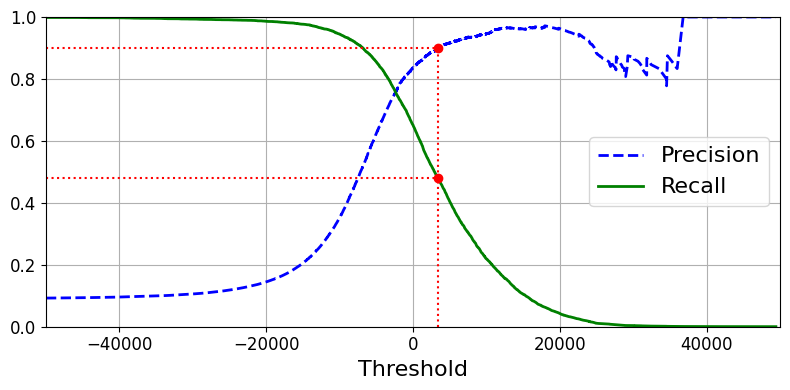

In [87]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # 임계값에 따른 정밀도와 재현율 그래프를 그리는 함수
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)  # 정밀도 (파란 점선)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)         # 재현율 (초록 실선)
    plt.legend(loc="center right", fontsize=16)  # 범례 표시
    plt.xlabel("Threshold", fontsize=16)         # x축: 임계값
    plt.grid(True)                               # 그리드 표시
    plt.axis([-50000, 50000, 0, 1])              # x축, y축 범위 설정

# 정밀도가 90% 이상인 지점 중 가장 먼저 나오는 지점의 재현율을 가져옴
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

# 정밀도가 90% 이상이 되는 최초의 임계값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 그림 크기 설정
plt.figure(figsize=(8, 4))

# 정밀도-재현율 vs 임계값 그래프 그리기
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# 수직선: 정밀도 90%가 되는 임계값 위치
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")

# 수평선: 정밀도 0.9 라인 (왼쪽 끝부터 임계값까지)
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")

# 수평선: 해당 임계값에서의 재현율 위치 표시
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

# 붉은 원으로 정밀도 90% 지점 표시
plt.plot([threshold_90_precision], [0.9], "ro")

# 붉은 원으로 재현율 값 지점도 표시
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

# 그래프 저장
save_fig("precision_recall_vs_threshold_plot")

# 그래프 표시
plt.show()


정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유
 - 임계값을 높이면 정밀도가 낮아질 수 있기 때문(일반적으로는 높아짐)

임계값 중앙에서 시작하여 오른쪽으로 한 자릿수 이동했을 때,  

 - 정밀도는 4/5(80%)에서 3/4(75%)로 낮아짐

재현율은 임계값을 높일 때만 낮아지므로 곡선이 매끈해 보인다!

In [89]:
(y_train_pred == (y_scores > 0)).all()  # y_train_pred(predict()의 결과) == y_scores > 0(직접 만든 조건부 예측)

np.True_

Saving figure precision_vs_recall_plot


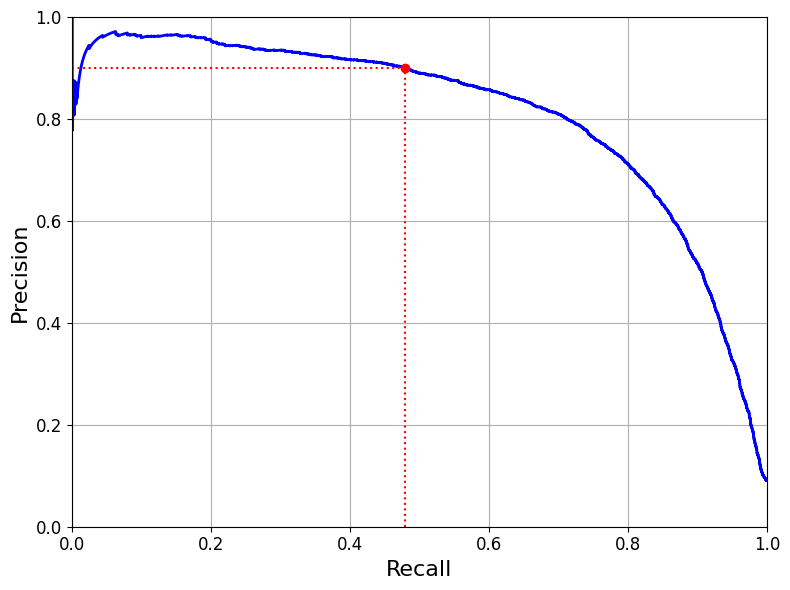

In [90]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)     # 재현율 vs 정밀도 그래프
    plt.xlabel("Recall", fontsize=16)                    # x축: 재현율
    plt.ylabel("Precision", fontsize=16)                 # y축: 정밀도
    plt.axis([0, 1, 0, 1])                               # 축 범위 설정
    plt.grid(True)                                       # 격자 표시

plt.figure(figsize=(8, 6))                               # 그래프 크기 설정
plot_precision_vs_recall(precisions, recalls)           # 정밀도-재현율 그래프 그리기
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")  # 수직선 (재현율 위치)
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")                 # 수평선 (정밀도 기준선)
plt.plot([recall_90_precision], [0.9], "ro")                            # 기준점 강조 (붉은 점)
save_fig("precision_vs_recall_plot")                     # 그래프 이미지 저장
plt.show()                                               # 그래프 출력


정밀도가 재현율 80% 부근에서 급격히 떨어지기 시작
 -> 따라서 그 직전, 재현율 60% 부근에서 정밀도/재현율 트레이드오프를 선택하는 것이 좋음
 (하지만 선택은 프로젝트에 따라 달라짐)
 
<90%의 정밀도를 목표로 한다고 가정>
 - 첫 번째 플롯을 확인해 보니 약 8,000의 임계값을 사용해야 함
 - 더 정확하게 하려면 최소 90%의 정밀도를 제공하는 가장 낮은 임계값을 검색(np.argmax()는 최대값의 첫 번째 인덱스를 제공하며, 이 경우 첫 번째 True 값을 의미)

In [91]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [92]:
threshold_90_precision

np.float64(3370.0194991439557)

In [93]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [100]:
precision_score(y_train_5, y_train_pred_90)  # 정밀도 확인 

0.9000345901072293

In [101]:
recall_score(y_train_5, y_train_pred_90)  # 재현율 확인

0.4799852425751706

90% 정밀도 분류기 -> 높은 정밀도 분류기라도 재현율이 너무 낮으면 별로 유용하지 않음 주의

## The ROC Curve

수신자 조작 특성(ROC) 곡선: 이진 분류기와 함께 사용되는 또 다른 일반적인 도구
 - 정밀도/재현율 곡선과 매우 유사
 - ROC 곡선은 정밀도 대 재현율을 그리는 대신 참긍정률(== 민감도, 재현율)과 참부정률(FPR) 표시
 - FPR: 양성으로 잘못 분류된 음성 사례의 비율, 1 - 참부정률(TNR)과 같음
 - TNR(True Negative Rate): 음성으로 올바르게 분류된 음성 사례의 비율, 특이도라고도 함
 - ROC 곡선은 민감도(재현율) 대 1 - 특이도를 표시

ROC 곡선을 그리기 위해 roc_curve() 함수를 사용하여 다양한 임계값에 대한 TPR과 FPR을 계산 선행

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


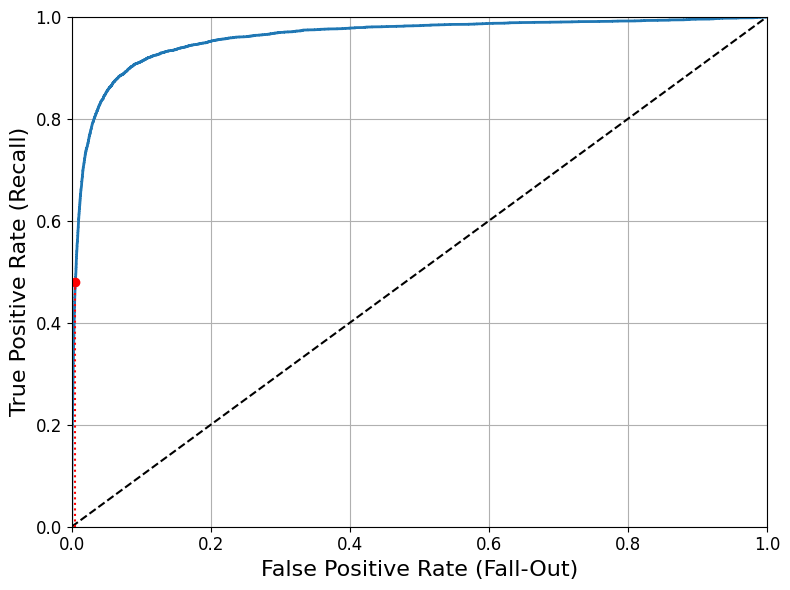

In [103]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)                   # ROC 곡선 그리기
    plt.plot([0, 1], [0, 1], 'k--')                                 # 기준선 (랜덤 분류기)
    plt.axis([0, 1, 0, 1])                                          # 축 범위 설정
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)      # x축: 거짓 양성 비율
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)         # y축: 참 양성 비율 (재현율)
    plt.grid(True)                                                 # 그리드 표시

plt.figure(figsize=(8, 6))                                         # 그래프 크기 설정
plot_roc_curve(fpr, tpr)                                          # ROC 곡선 그리기

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]               # 재현율 90% 이상인 지점의 FPR 추출
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")       # FPR 기준선 (수직)
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # 재현율 기준선 (수평)
plt.plot([fpr_90], [recall_90_precision], "ro")                   # 기준점 강조 (붉은 점)

save_fig("roc_curve_plot")                                        # 그래프 저장
plt.show()                                                        # 그래프 표시


재현율(TPR)이 높을수록 분류기가 생성하는 거짓긍정률(FPR)도 높아짐  
점선은 순수 무작위 분류기의 ROC 곡선  
좋은 분류기는 이 선에서 가능한 한 멀리(좌상단 모서리 쪽) 떨어져 있다!

분류기를 비교하는 방법 중 하나 -> 곡선 아래 면적(AUC)을 측정  
완벽한 분류기는 ROC AUC가 1, 순수 무작위 분류기는 ROC AUC가 0.5  

In [104]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC 곡선은 정밀도/재현율(PR) 곡선과 매우 유사함!  
일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때는 PR 곡선을 사용, 아니면 ROC 곡선 사용

이전 ROC 곡선(및 ROC AUC 점수)을 보면 분류기가 정말 좋다고 생각할 수 있으나,  
하지만 이는 대부분 음성(5가 아닌)에 비해 양성(5)이 적기 때문  
 -> 반면 PR 곡선은 분류기에 개선의 여지가 있음을  보여 줌(곡선이 왼쪽 상단 모서리에 더 가까울 수 있음)

이제 RandomForestClassifier를 학습시키고 ROC 곡선과 ROC AUC 점수를 SGDClassifier의 점수와 비교

먼저, 학습 세트의 각 인스턴스에 대한 점수를 얻어야 함  
하지만 작동 방식 때문에 Random ForestClassifier 클래스에는 decision_function() 메서드가 없음  
대신 predict_proba() 메서드가 있음

Scikit-Learn 분류기는 일반적으로 이 두 가지 메서드 중 하나, 또는 둘 다를 가지고 있음   
predict_proba() 메서드는 인스턴스당 행과 클래스당 열을 포함하는 배열을 반환  
각 행에는 주어진 인스턴스가 주어진 클래스에 속할 확률이 포함(예: 이미지가 5를 나타낼 확률 70%)

In [107]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 분류기 생성 (100개의 트리, 랜덤 시드 42)
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 교차 검증을 통해 각 샘플에 대한 클래스 확률 예측
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")


roc_curve() 함수는 레이블과 점수를 필요로 하지만,   
점수 대신 클래스 확률을 지정할 수 있음 -> 긍정 클래스의 확률을 점수로 사용

In [109]:
y_scores_forest = y_probas_forest[:, 1]  # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


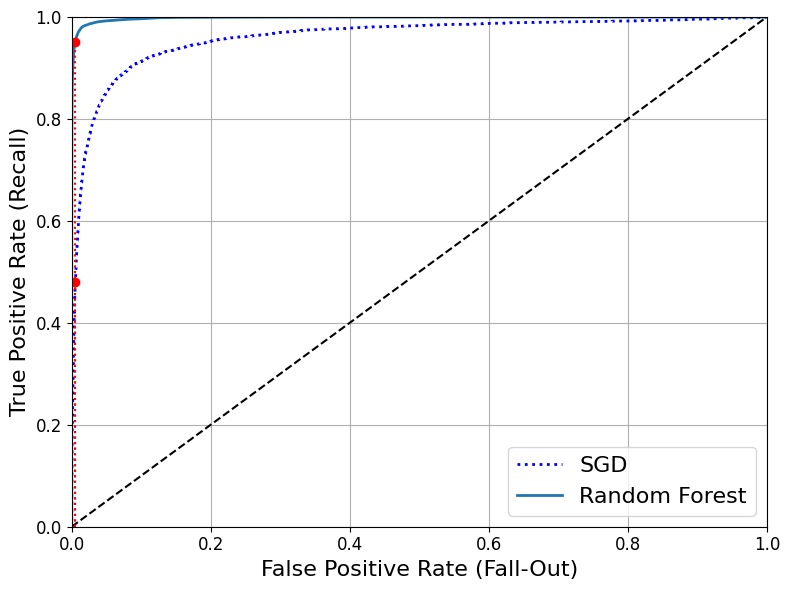

In [154]:
# 랜덤 포레스트에서 fpr_90 이상일 때의 재현율 추출
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))  # 그래프 크기 설정

# SGDClassifier의 ROC 곡선 (점선)
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")

# 랜덤 포레스트의 ROC 곡선
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

# 기준점 (fpr_90, recall_90_precision) 표시
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

# 랜덤 포레스트 기준점 표시
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")  # 그래프 저장
plt.show()  # 그래프 출력


랜덤 포레스트 분류기는 SGD 분류기보다 ROC 곡선이 좌측 상단 모서리에 훨씬 가깝고 AUC가 더 크기 때문에 더 __우수하다!__

In [111]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [112]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [113]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

ROC AUC 점수도 더 좋고, 정밀도와 재현율 점수도 좋음

이제 5점 이상의 값을 검출해 보기!

# 4. Multiclass Classification

이진 분류기는 두 클래스를 구분, 다중 클래스 분류기(다항 분류기)는 두 개 이상의 클래스 구분

SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등은 여러 클래스를 처리  
로지스틱 회귀 또는 지원 벡터 머신 분류기는 엄격한 이진 분류기

여러 이진 분류기를 사용하여 다중 클래스 분류 수행 가능

숫자 이미지를 10개의 클래스(0~9)로 분류할 수 있는 시스템 전략
1. 일대나머지(OvR) 전략
- 각 숫자에 대해 하나씩(0 검출기, 1 검출기, 2 검출기 등) 10개의 이진 분류기 훈련
- 그런 다음 이미지를 분류하려면 해당 이미지에 대한 각 분류기에서 결정 점수를 얻고
- 분류기에서 가장 높은 점수를 출력하는 클래스 선택

2.  일대일(OvO) 전략
- 모든 숫자 쌍에 대해 이진 분류기 학습시키기
- 하나는 0과 1을 구분하고, 다른 하나는 0과 2를 구분하고, 또 다른 하나는 1과 2를 구분하는 식으로 진행
- 클래스가 N개이면 N × (N – 1) / 2개의 분류기를 학습해야 함

MNIST 문제의 경우 45개의 이진 분류기 학습임  
이미지를 분류하려면 45개의 분류기 모두에 이미지를 통과시키고 어느 클래스가 가장 많은 승리에서 승리하는지 확인

OvO의 주요 장점: 각 분류기가 구분해야 하는 두 클래스에 대한 학습 세트의 일부에 대해서만 학습하면 된다  
일부 알고리즘(예: 지원 벡터 머신 분류기)은 학습 세트 크기에 따라 확장성이 떨어지므로 OvO가 선호됨  
-> 작은 학습 세트에서 여러 분류기를 학습하는 것이 큰 학습 세트에서 적은 분류기를 학습하는 것보다 빠르기 때문  
그러나 대부분의 이진 분류 알고리즘에서는 OvR이 선호  

Scikit-Learn은 다중 클래스 분류 작업에 이진 분류 알고리즘을 사용하려고 할 때 이를 감지하고,  
알고리즘에 따라 OvR 또는 OvO를 자동으로 실행함  
sklearn.svm.SVC 클래스를 사용하여 지원 벡터 머신 분류기로 이 과정 시도

In [120]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)                    # SVM 분류기 생성
svm_clf.fit(X_train[:1000], y_train[:1000])                     # 전체 다섯이 아닌 원래 숫자 레이블로 학습
svm_clf.predict([some_digit])                                   # 숫자 예측


array([5], dtype=uint8)

In [121]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

decision_function() 메서드를 호출하면 인스턴스당 1개가 아닌 10개의 점수를 반환  
-> 즉, 클래스당 하나의 점수가 반환되는 것

In [123]:
np.argmax(some_digit_scores)  # 가장 큰 값을 가진 인덱스(위치)은 5

np.int64(5)

In [125]:
svm_clf.classes_  # 모델이 학습한 클래스(레이블)들의 목록

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [126]:
svm_clf.classes_[5]  # 모델이 학습한 클래스 중 5번째 인덱스에 해당하는 클래스 라벨

np.uint8(5)

분류기가 학습되면 대상 클래스 목록을 classes_ 속성에 값 순으로 저장  
이 경우 classes_ 배열의 각 클래스 인덱스는 클래스 자체와 일치(예: 인덱스 5에 있는 클래스는 클래스 5)  
일반적으로는 아님!

Scikit-Learn에서 일대일 또는 일대다 분류를 사용하도록 강제하기  
 -> OneVsOneClassifier 또는 OneVsRestClassifier 클래스  
인스턴스를 생성하고 생성자에 분류기 전달  

예를 들어, 다음 코드는 SVC를 기반으로 OvR 전략을 사용하여 다중 클래스 분류기를 생성

In [127]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [128]:
len(ovr_clf.estimators_)

10

SGDClassifier(또는 RandomForestClassifier) 훈련하기

In [129]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [130]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [133]:
# 분류기 평가하기
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 훈련 데이터를 표준화 (평균 0, 분산 1)
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# 표준화된 데이터로 SGDClassifier 정확도 평가 (3-폴드 교차 검증)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

# 5. Error Analysis

실제 프로젝트라고 가정하면, 머신 러닝 프로젝트 체크리스트(부록 B 참조)의 단계를 따른다  
1. 데이터 준비 옵션을 살펴보기
2. 여러 모델을 시도해 보기(가장 적합한 모델을 선정하고 GridSearchCV를 사용하여 하이퍼파라미터 미세 조정)
3. 가능한 한 많은 부분 자동화

여기서는 유망한 모델을 찾았고 이를 개선할 방법을 찾고 있다고 가정함  
이를 위한 한 가지 방법은 모델에서 발생하는 오류 유형을 분석하는 것

In [135]:
# 혼동행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Saving figure confusion_matrix_plot


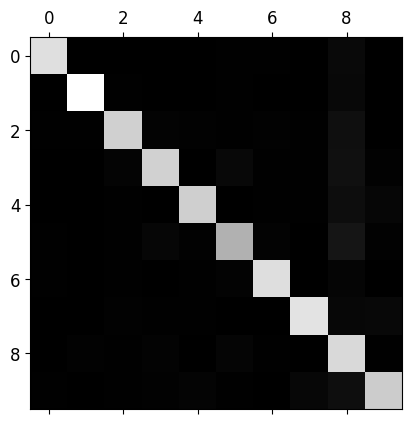

In [136]:
# 숫자가 많으므로 Matplotlib의 matshow() 함수를 사용하여 혼동 행렬의 이미지 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

대부분의 이미지가 주 대각선에 있음 -> 이미지가 올바르게 분류됨  
5는 다른 숫자보다 약간 어둡게 보이는데, 
 - 데이터셋에 5 이미지가 적거나 
 - 분류기가 숫자 5를 다른 숫자보다 잘 분류하지 못한다는 뜻(실제로 두 경우 모두 해당)

오류에 집중한 그래프를 살펴보기  
먼저 혼동 행렬의 각 값을 해당 클래스(실제 숫자)에 속한 이미지 수로 나누어야  
오류 개수 자체가 아니라 오류 비율(오류율)을 비교할 수 있음!  
(단순 오류 개수를 보면 많이 등장하는 숫자 클래스가 더 나쁘게 보일 수 있기 때문)

In [137]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 각 클래스별 전체 이미지 수
norm_conf_mx = conf_mx / row_sums              # 클래스별로 정규화된 혼동 행렬 (비율로 변환)


Saving figure confusion_matrix_errors_plot


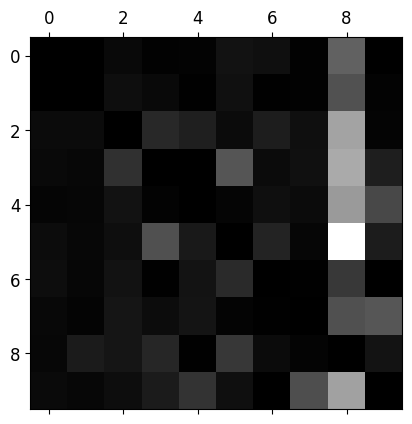

In [139]:
np.fill_diagonal(norm_conf_mx, 0)                # 정확히 맞춘 항목(대각선)을 0으로 설정 → 오류만 강조
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)      # 정규화된 오류 행렬 시각화 (회색톤)
save_fig("confusion_matrix_errors_plot", tight_layout=False)  # 그래프 저장
plt.show()                                       # 그래프 출력


분류기가 어떤 종류의 오류를 자주 범하는지 확실히 확인할 수 있음
 - 혼동 행렬에서 행은 실제 클래스(정답)
 - 열은 예측한 클래스

클래스 8의 열이 상당히 밝게 보임  
-> 다른 숫자들이 8로 잘못 분류되는 경우가 많다  

하지만 클래스 8의 행은 그렇게 나쁘지 않음  
-> 실제 숫자 8은 대부분 정확히 8로 잘 분류되고 있다  
=> 혼동 행렬은 대칭이 아닐 수도 있다  

숫자 3과 5가 서로 자주 혼동(양방향으로 오답이 많이 발생함)

_이런 혼동 행렬 분석은 분류기를 개선하는 데 좋은 힌트!_  
-> false 8 문제를 줄이는 데 노력을 집중해야 함!

__문제 개선 방법__
1. 8처럼 생겼지만 실제로는 다른 숫자인 이미지들을 더 많이 수집해
 - 분류기가 8과 비슷한 다른 숫자들을 더 잘 구분하도록 훈련시키기

2. 새로운 특성(feature)을 설계하기
 - 숫자 내부의 닫힌 고리 수(폐곡선)를 세는 알고리즘 만들기
 - 8은 고리가 2개, 6은 1개, 5는 없음

3. 이미지를 전처리(preprocessing)
 - Scikit-Image, Pillow, OpenCV 등 이용
 - 닫힌 고리 같은 시각적 패턴을 더 잘 드러나게 만들기

cl_a, cl_b = 3, 5  # 비교할 두 숫자 클래스

# 실제 3인데 3으로 예측
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# 실제 3인데 5로 예측 (오답)
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# 실제 5인데 3으로 예측 (오답)
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# 실제 5인데 5로 예측
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))  # 전체 그림 크기 설정
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 정답: 3, 예측: 3
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 정답: 3, 예측: 5
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 정답: 5, 예측: 3
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 정답: 5, 예측: 5

save_fig("error_analysis_digits_plot")  # 그림 저장
plt.show()  # 그림 출력


왼쪽에 있는 두 개의 5×5 블록은 모델이 3이라고 분류한 이미지들이고  
오른쪽의 두 블록은 모델이 5라고 분류한 이미지들

왼쪽 아래(실제 5인데 3으로 예측)와 오른쪽 위(실제 3인데 5로 예측) 블록을 보면  
몇몇 숫자는 정말 너무 엉망으로 쓰여 있어서 사람조차도 구별하기 어려운 경우가 있음

하지만 대부분의 오답 이미지는 사람 입장에서 보면 분명히 잘못 분류된 것처럼 보이고  
모델이 왜 그렇게 예측했는지 이해하기 어렵다,,  
 -> 우리가 사용한 분류기가 SGDClassifier(선형 모델)이기 때문

 - 각 픽셀에 대해 클래스별 가중치를 부여
 - 새로운 이미지를 볼 때는 단순히 픽셀 값 × 가중치를 다 더해서 각 클래스의 점수를 계산

=> 숫자 3과 5는 몇 개의 픽셀만 다르고 전체적인 모양이 비슷하기 때문에, 이 모델은 쉽게 둘을 헷갈림

# 6. Multilabel Classification(다중 레이블 분류)

지금까지는 각 샘플(이미지 등)에 대해 항상 하나의 클래스만 예측했으나  
어떤 경우에는 하나의 샘플에 대해 여러 개의 클래스를 예측해야 할 수도 있다!  
(예, 얼굴 인식(facerecognition) 분류기)  
한 사진에 여러 사람이 등장하면 사진 속에서 인식한 사람마다 하나씩 태그를 붙여야  

**다중 레이블 분류(multilabel classification)**: 각 클래스마다 이진(yes/no) 형태의 태그를 여러 개 출력하는 분류 시스템

In [144]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)               # 7 이상이면 True
y_train_odd = (y_train % 2 == 1)             # 홀수면 True
y_multilabel = np.c_[y_train_large, y_train_odd]  # 다중 레이블 배열 생성

knn_clf = KNeighborsClassifier()              # 다중 레이블 분류를 지원하지만 모든 분류기가 지원하는 것은 아님
knn_clf.fit(X_train, y_multilabel)           # 다중 레이블 학습


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [145]:
knn_clf.predict([some_digit])

array([[False,  True]])

모델이 맞힘: 숫자 5는 실제로 크지 않음(False)이고 홀수(True)

다중 레이블 분류기(multilabel classifier)를 평가하는 방법에는 여러 가지가 있으며,  
어떤 평가 지표를 사용할지는 프로젝트의 목적에 따라 달라짐

한 가지 방법은  
각 레이블(태그)에 대해 F1 점수(또는 앞서 배운 다른 이진 분류 지표)를 개별적으로 계산한 뒤,  
그 점수들의 평균을 구하는 방식  

모든 레이블에 대해 평균 F1 점수를 계산하는 예시:

In [147]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") 

0.9764102655606048

이는 모든 레이블이 동등하게 중요하다고 가정하지만, 실제로는 그렇지 않을 수 있음
특히 A나 B보다 C 사진이 훨씬 더 많은 경우, C 사진에 대한 분류기의 점수에 더 많은 가중치 부여

한 가지 간단한 방법은  
각 레이블에 해당 레이블의 지지도(즉, 해당 대상 레이블을 가진 인스턴스의 수)와 동일한 가중치 부여   
-> average="weighted" 설정

# 7. Multioutput Classification

다중 출력-다중 클래스 분류(또는 다중 출력 분류)
이는 다중 레이블 분류를 일반화한 것
각 레이블이 다중 클래스일 수 있다(즉, 두 개 이상의 가능한 값을 가질 수 있음)

이를 설명하기 위해 이미지에서 노이즈를 제거하는 시스템 만들기
 - 노이즈가 있는 숫자 이미지를 입력으로 받고
 - MNIST 이미지처럼 픽셀 강도 배열로 표현된 깨끗한 숫자 이미지를 출력(바람직하게)
 - 분류기의 출력은 다중 레이블(픽셀당 하나의 레이블)이고 각 레이블은 여러 값을 가질 수 있음(픽셀 강도 범위는 0~255)

※ 주의  
분류와 회귀의 경계는 모호할 때가 있다.    
픽셀 강도를 예측하는 것은 분류보다는 회귀에 더 가까움   
더욱이 다중 출력 시스템은 분류 작업에만 국한되지 X  
클래스 레이블과 값 레이블을 모두 포함하여 인스턴스당 여러 레이블을 출력하는 시스템을 구축할 수도 있음

In [149]:
noise = np.random.randint(0, 100, (len(X_train), 784))  # 훈련용 랜덤 노이즈 생성
X_train_mod = X_train + noise                           # 훈련 이미지에 노이즈 추가

noise = np.random.randint(0, 100, (len(X_test), 784))   # 테스트용 랜덤 노이즈 생성
X_test_mod = X_test + noise                             # 테스트 이미지에 노이즈 추가

y_train_mod = X_train                                   # 원본 이미지(정답) 저장
y_test_mod = X_test


Saving figure noisy_digit_example_plot


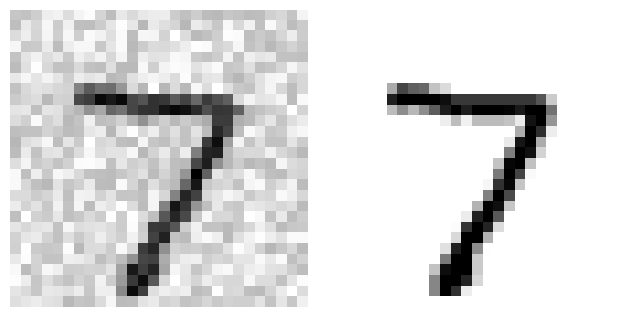

In [152]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])  # 노이즈 추가된 이미지 표시
plt.subplot(122); plot_digit(y_test_mod[some_index])  # 원본 이미지 표시
save_fig("noisy_digit_example_plot")                  # 이미지 저장
plt.show()                                            # 그래프 출력


Saving figure cleaned_digit_example_plot


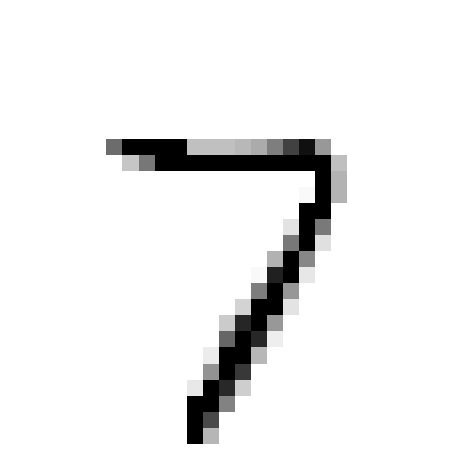

In [153]:
knn_clf.fit(X_train_mod, y_train_mod)                     # 노이즈 이미지 → 원본 이미지로 학습
clean_digit = knn_clf.predict([X_test_mod[some_index]])   # 노이즈 이미지 복원 예측
plot_digit(clean_digit)                                   # 복원된 이미지 시각화
save_fig("cleaned_digit_example_plot")                    # 이미지 저장
